在上一教程中，您介绍了用于自动区分的TensorFlow API-这是机器学习的基本构建块。在本教程中，您将使用之前教程中介绍的TensorFlow原语进行一些简单的机器学习。

TensorFlow还包括tf.keras一个高级神经网络API，该API提供有用的抽象来减少样板，并在不牺牲灵活性和性能的情况下使TensorFlow易于使用。我们强烈建议您使用tf.Keras API进行开发。但是，在这个简短的教程中，您将学习如何从基本原理训练神经网络以建立牢固的基础。

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

In [2]:
import numpy as np

变量

TensorFlow中的Tensor是不可变的无状态对象。但是，机器学习模型必须具有变化的状态：随着模型的训练，用于计算预测的相同代码在时间上的行为应有所不同（希望损失更低！）。为了表示这种状态，需要在计算过程中改变它，您可以选择依赖Python是一种有状态的编程语言这一事实​​：

In [3]:
# Using Python state
x = tf.zeros([10, 10])
x += 2  # This is equivalent to x = x + 2, which does not mutate the original
        # value of x
print(x)

tf.Tensor(
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]], shape=(10, 10), dtype=float32)


TensorFlow内置了有状态操作，与使用低级Python表示状态相比，这些操作通常更容易。使用tf.Variable来表示一个模型权重。

一个tf.Variable对象存储的值，并且隐式地从该存储值读出。有一些操作（tf.assign_sub，tf.scatter_update等）可操纵存储在TensorFlow变量中的值。

In [4]:
v = tf.Variable(1.0)
# Use Python's `assert` as a debugging statement to test the condition
assert v.numpy() == 1.0

# Reassign the value `v`
v.assign(3.0)
assert v.numpy() == 3.0

# Use `v` in a TensorFlow `tf.square()` operation and reassign
v.assign(tf.square(v))
assert v.numpy() == 9.0

计算tf.Variable梯度时会自动跟踪使用的计算。对于表示嵌入的变量，默认情况下，TensorFlow会进行稀疏更新，这将提高计算和内存效率。

A tf.Variable也是一种向代码的读者显示状态是可变的方式。

拟合线性模型
让我们用你学到了远的概念Tensor，Variable和GradientTape-to建立和培养一个简单的模型。这通常涉及几个步骤：

1. 定义模型。
2. 定义损失函数。
3. 获取培训数据。
4. 遍历训练数据，并使用“优化器”调整变量以适合数据。

在这里，您将创建一个简单的线性模型，f(x) = x * W + b该模型具有两个变量：（W权重）和b（偏差）。您将合成数据，以便训练有素的模型具有W = 3.0和b = 2.0。

定义模型<br>
让我们定义一个简单的类来封装变量和计算：

In [5]:
class Model(object):
    def __init__(self):
        # Initialize the weights to `5.0` and the bias to `0.0`
        # In practice, these should be initialized to random values (for example, with `tf.random.normal`)
        self.W = tf.Variable(5.0)
        self.b = tf.Variable(0.0)

    def __call__(self, x):
        return self.W * x + self.b

model = Model()

assert model(3.0).numpy() == 15.0

定义损失函数<br>
损失函数衡量给定输入的模型输出与目标输出的匹配程度。目的是在训练过程中尽量减少这种差异。让我们使用标准的L2损失，也称为最小平方误差：

In [6]:
def loss(predicted_y, target_y):
    return tf.reduce_mean(tf.square(predicted_y - target_y))

获取训练数据<br>
首先，通过向输入中添加随机高斯（Normal）噪声来合成训练数据：

In [7]:
TRUE_W = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

inputs  = tf.random.normal(shape=[NUM_EXAMPLES])
noise   = tf.random.normal(shape=[NUM_EXAMPLES])
outputs = inputs * TRUE_W + TRUE_b + noise

在训练模型之前，通过以红色绘制模型的预测并以蓝色绘制训练数据来可视化损失值：

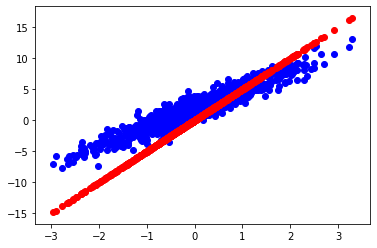

Current loss: 8.724603


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(inputs), c='r')
plt.show()

print('Current loss: %1.6f' % loss(model(inputs), outputs).numpy())

定义训练循环<br>
利用网络和训练数据，使用梯度下降训练模型以更新权重变量（W）和偏差变量（b）以减少损失。我们tf.train.Optimizer推荐的实现中包含了梯度下降方案的许多变体。但是，本着从第一条原则进行构建的精神，您将在这里借助tf.GradientTape自动微分和tf.assign_sub递减值（结合tf.assign和tf.sub）来实现基本数学：

In [9]:
def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as t:
        current_loss = loss(model(inputs), outputs)
    dW, db = t.gradient(current_loss, [model.W, model.b])
    model.W.assign_sub(learning_rate * dW)
    model.b.assign_sub(learning_rate * db)

最后，让我们通过反复训练数据运行，看看W和b发展。

Epoch  0: W=5.00 b=0.00, loss=8.72460
Epoch  1: W=4.59 b=0.37, loss=5.94735
Epoch  2: W=4.26 b=0.67, loss=4.17319
Epoch  3: W=4.00 b=0.91, loss=3.03942
Epoch  4: W=3.79 b=1.11, loss=2.31464
Epoch  5: W=3.63 b=1.27, loss=1.85116
Epoch  6: W=3.50 b=1.39, loss=1.55467
Epoch  7: W=3.40 b=1.50, loss=1.36495
Epoch  8: W=3.32 b=1.58, loss=1.24351
Epoch  9: W=3.25 b=1.65, loss=1.16576


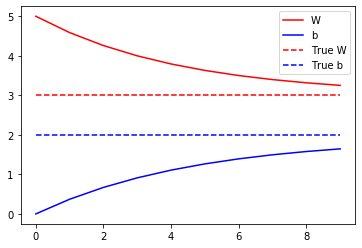

In [10]:
model = Model()

# Collect the history of W-values and b-values to plot later
Ws, bs = [], []
epochs = range(10)
for epoch in epochs:
    Ws.append(model.W.numpy())
    bs.append(model.b.numpy())
    current_loss = loss(model(inputs), outputs)
  
    train(model, inputs, outputs, learning_rate=0.1)
    print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' %
        (epoch, Ws[-1], bs[-1], current_loss))

# Let's plot it all
plt.plot(epochs, Ws, 'r',
         epochs, bs, 'b')
plt.plot([TRUE_W] * len(epochs), 'r--',
         [TRUE_b] * len(epochs), 'b--')
plt.legend(['W', 'b', 'True W', 'True b'])
plt.show()

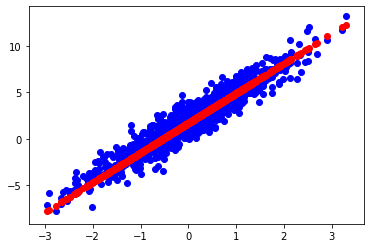

Current loss: 1.115961


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(inputs), c='r')
plt.show()

print('Current loss: %1.6f' % loss(model(inputs), outputs).numpy())

下一步<br>
本教程用于tf.Variable构建和训练简单的线性模型。

实际上，高级API（例如tf.keras）在构建神经网络时要方便得多。tf.keras提供了更高级别的构建块（称为“层”），用于保存和恢复状态的实用程序，一套损失函数，一套优化策略等。阅读TensorFlow Keras指南以了解更多信息。

## 自己测试

In [34]:
model=tf.keras.models.Sequential(tf.keras.layers.Dense(1))

In [35]:
model.compile(optimizer='sgd',
              loss='mse',
              metrics=['mse'])

In [36]:
model.fit(inputs,outputs,epochs=10)

Train on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 0s 339us/sample - loss: 10.0580 - mse: 10.0580
Epoch 2/10
1000/1000 [==============================] - 0s 122us/sample - loss: 3.2374 - mse: 3.2374
Epoch 3/10
1000/1000 [==============================] - 0s 113us/sample - loss: 1.5652 - mse: 1.5652
Epoch 4/10
1000/1000 [==============================] - 0s 126us/sample - loss: 1.1566 - mse: 1.1566
Epoch 5/10
1000/1000 [==============================] - 0s 128us/sample - loss: 1.0611 - mse: 1.0611
Epoch 6/10
1000/1000 [==============================] - 0s 120us/sample - loss: 1.0368 - mse: 1.0368
Epoch 7/10
1000/1000 [==============================] - 0s 118us/sample - loss: 1.0310 - mse: 1.0310
Epoch 8/10
1000/1000 [==============================] - 0s 126us/sample - loss: 1.0288 - mse: 1.0288
Epoch 9/10
1000/1000 [==============================] - 0s 123us/sample - loss: 1.0283 - mse: 1.0283
Epoch 10/10
1000/1000 [==============================] - 0s 129us/s

In [40]:
model.layers[0].weights[0].numpy()

array([[2.9908278]], dtype=float32)

In [41]:
model.layers[0].weights[1].numpy()

array([1.9202532], dtype=float32)

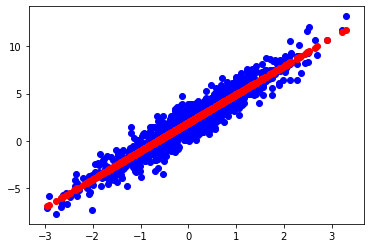

Current loss: 20.219213


In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model.predict(inputs), c='r')
plt.show()

print('Current loss: %1.6f' % loss(model.predict(inputs), outputs).numpy())